In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split


In [6]:
from AFML_module.dataset_utilities import (get_instrument_attributes, 
                                           form_dollar_bars, 
                                           form_time_bars,
                                           form_vol_bars,
                                           reduce_to_active_symbols, 
                                           apply_roll_factors)

from AFML_module.triple_barrier_utilities import (get_daily_rolling_volatility,
                                                  get_vertical_barriers,
                                                  detect_crossed_barriers_for_events)

from AFML_module.cusum_filter import apply_cusum_filter



In [7]:
from AFML_module.config import RAW_DATA_DIR

data = pd.read_parquet(RAW_DATA_DIR/"sp_emini_data.parquet", engine="pyarrow")
instrument_frame = pd.read_parquet(RAW_DATA_DIR/"instrument_frame.parquet", engine="pyarrow")

In [24]:
# Sample more frequently to get more events

dollar_bars = form_dollar_bars(data, 100*10_000_000, sort=True)
active_only_dollar_bars = reduce_to_active_symbols(dollar_bars, instrument_frame)
rolled_dollar_bars = apply_roll_factors(active_only_dollar_bars, sort=False)

In [25]:
rolling_vol = get_daily_rolling_volatility(rolled_dollar_bars)

In [26]:
def form_uniqueness_indicator_matrix(events, barrier_touches, num_bars):
    indicator_matrix = np.zeros((num_bars, len(events)))
    for idx, event in enumerate(events):
        start = event
        stop = barrier_touches[event]
        indicator_matrix[start:stop+1, idx] = 1
    
    return indicator_matrix


def count_bar_contributions( events, barrier_touches, num_bars ):
    # for each bar, computs how many events it contributes to
    indicator_matrix = form_uniqueness_indicator_matrix( events, barrier_touches, num_bars )

    return indicator_matrix.sum(axis=1)


def get_average_uniqueness(indicator_matrix):
    # indicator_matrix.shape ~ (bar x label)
    c = indicator_matrix.sum(axis=1)
    
    mask = c != 0
    
    inv_c = np.zeros_like(c, dtype=float)
    inv_c[mask] = 1.0 / c[mask]
    
    avgU = (indicator_matrix.T @ inv_c) / indicator_matrix.sum(axis=0)
    
    return np.nan_to_num(avgU, nan=0.0)


def seq_bootstrap(indicator_matrix, sLength=None):

    if sLength is None: 
        sLength = indicator_matrix.shape[1]

    phi = []
    choices = np.arange(indicator_matrix.shape[1])
    for _ in range(sLength):
    
        # compute probability distribution for draw
        avgU = np.zeros(indicator_matrix.shape[1])
        
        for i in range(indicator_matrix.shape[1]):
            reduced = indicator_matrix[:, phi + [i]]
            avgU[i] = get_average_uniqueness(reduced)[-1]
            
        prob = avgU / avgU.sum()
        
        # make draw
        phi += [np.random.choice(choices, p=prob)]

    return np.array(phi)
            

# Exercises

In Chapter 3, we denoted as t1 a pandas series of timestamps where the first
barrier was touched, and the index was the timestamp of the observation. This
was the output of the getEvents function.

(a) Compute a t1 series on dollar bars derived from E-mini S&P 500 futures
tick data.

(b) Apply the function mpNumCoEvents to compute the number of overlapping
outcomes at each point in time.

(c) Plot the time series of the number of concurrent labels on the primary axis,
and the time series of exponentially weighted moving standard deviation of
returns on the secondary axis.

(d) Produce a scatterplot of the number of concurrent labels (x-axis) and the
exponentially weighted moving standard deviation of returns (y-axis). Can
you appreciate a relationship?

In [39]:
# First, we compute a series of barrier touches as in the prior chapter, based on 
# events sampled with the CUSUM filter
events = apply_cusum_filter(rolled_dollar_bars, 0.01)
events = events[:-10] # drop events that occur at end of dataframe where vertical barrier cannot be formed

lower_series = rolling_vol["daily volatility"]
upper_series = rolling_vol["daily volatility"]
vertical_barriers = get_vertical_barriers(rolled_dollar_bars, time_thresh="1d")

upper_factor = 1
lower_factor = 1

labelled_events = detect_crossed_barriers_for_events(rolled_dollar_bars, 
                                                     events, 
                                                     lower_series, 
                                                     upper_series, 
                                                     lower_factor, 
                                                     upper_factor,
                                                     vertical_barriers)

# gives the index in rolled_dollar_bars where the barrier touch occurs
barrier_touches = labelled_events["first touch"]



# for each bar, compute how many events it contributes to
bar_contributions = count_bar_contributions(events, barrier_touches, rolled_dollar_bars.shape[0])

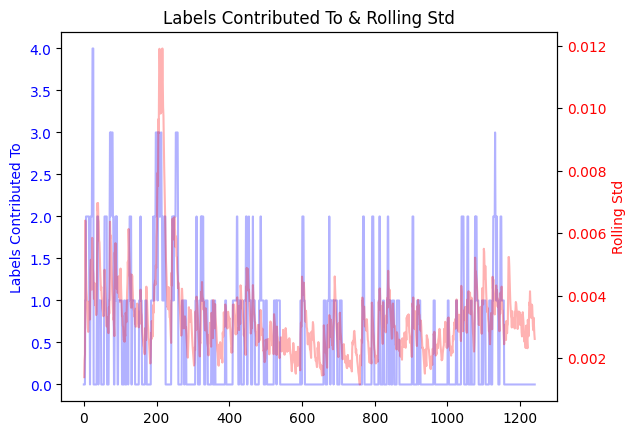

Correlation Coefficient: 0.5841445815295248


In [44]:
rolling_std = rolled_dollar_bars["return"].ewm(span=10).std().to_numpy()

fig, ax1 = plt.subplots()

ax1.plot(bar_contributions, color='blue', label="Bar Contributions", alpha=0.3)
ax1.set_ylabel('Labels Contributed To', color='blue')
ax1.tick_params(axis='y', labelcolor='blue') 

ax2 = ax1.twinx()
ax2.plot(rolling_std, color='red', label='Rolling Std', alpha=0.3)
ax2.set_ylabel('Rolling Std', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Labels Contributed To & Rolling Std")
plt.show()

print(f"Correlation Coefficient: {np.corrcoef(rolling_std[1:], bar_contributions[1:])[0, 1]}")

Text(0.5, 1.0, 'Rolling Std. Vs Concurrent Events')

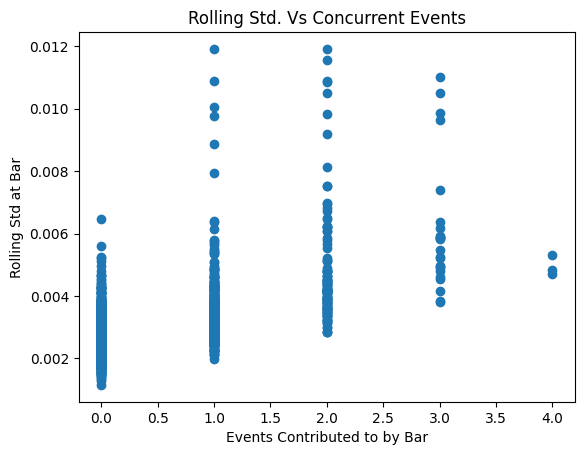

In [48]:
plt.scatter(bar_contributions, rolling_std)
plt.ylabel("Rolling Std at Bar")
plt.xlabel("Events Contributed to by Bar")
plt.title("Rolling Std. Vs Concurrent Events")

There is a significant correlation between information overlap and rolling volatility. This is because when there are volatility clusters, events are triggered more often, meaning more overlapping bars